This notebook describes some preliminary model building processes as I (mark burghart) start to build the 7 day mortality risk model to be used in Mediware Carepoint tool. The plan is to start with a simple logistic regression and tune to improve performance. <br>
<br>
General modeling process notes:<br>
- Training/test split will be 70%/30%. The test set will be held out until final model and inputs are defined.
- 5-fold cross validation of the training set will be used for model tuning and variable selection.
- Recursive feature selection will be used for variable selection.
- Grid search will be used for parameter tuning and threshold decision placement.<br>
<br>
Data is loaded from the carepoint_feature_engineering_py3 script and is labeled `carepoint_transformed.csv`. This data set does contain null values (which will need to be converted) and does not dummify categorical variables.



In [1]:
#load libraries
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier #baseline model
from sklearn import metrics

C:\tooling\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load data
df_load = pd.read_csv('C:/Users/Mark.Burghart/Documents/projects/hospice_carepoint/data/transformed/carepoint_transformed.csv')

In [3]:
df_load.head()

,Unnamed: 0,AdmissionKey,PatientKey,ZIPCode,StartOfCare,DischargeDate,patienttaskkey,gender,DateofBirth,DischargeType,...,Tiredness_change,Wellbeing_change,Age,death_within_7_days,ESAS_visit_total,3_visit_max_esas,5_visit_max_esas,3_visit_mean_esas,5_visit_mean_esas,ESAS_change
0,204866,6347577,1605855,78852,2017-11-09 00:00:00.000,2017-11-17 00:00:00.000,411870390,2,1934-05-08,Live,...,NaN,NaN,83.508902,0,22.0,NaN,NaN,NaN,NaN,NaN
1,204867,6347577,1605855,78852,2017-11-09 00:00:00.000,2017-11-17 00:00:00.000,412011716,2,1934-05-08,Live,...,0.0,0.0,83.519853,0,22.0,NaN,NaN,NaN,NaN,0.0
2,204868,6347577,1605855,78852,2017-11-09 00:00:00.000,2017-11-17 00:00:00.000,412011717,2,1934-05-08,Live,...,-1.0,0.0,83.525329,0,21.0,22.0,NaN,21.666667,NaN,-1.0
3,72826,5817025,1608150,78827,2017-06-30 00:00:00.000,2017-11-07 00:00:00.000,377875738,1,1937-07-02,Live,...,NaN,NaN,79.996167,0,19.0,NaN,NaN,NaN,NaN,NaN
4,72828,5817025,1608150,78827,2017-06-30 00:00:00.000,2017-11-07 00:00:00.000,379460838,1,1937-07-02,Live,...,0.0,2.0,80.004381,0,34.0,NaN,NaN,NaN,NaN,15.0


In [4]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271541 entries, 0 to 271540
Data columns (total 94 columns):
Unnamed: 0                        271541 non-null int64
AdmissionKey                      271541 non-null int64
PatientKey                        271541 non-null int64
ZIPCode                           271541 non-null int64
StartOfCare                       271541 non-null object
DischargeDate                     270230 non-null object
patienttaskkey                    271541 non-null int64
gender                            271541 non-null int64
DateofBirth                       271541 non-null object
DischargeType                     271541 non-null object
DischargeStatus                   271541 non-null object
DischargeReason                   53206 non-null object
AdvanceDirective                  271512 non-null object
TerminalDiagnosis                 271541 non-null object
DiagnosisDesc                     271541 non-null object
ReferralType                      271540 

In [5]:
#drop unnecessary columns for model building
df = df_load.drop(['Unnamed: 0', 'AdmissionKey', 'PatientKey', 'ZIPCode', 'StartOfCare', 'DischargeDate', 'patienttaskkey', 
                  'DateofBirth', 'DischargeType', 'DischargeStatus', 'DischargeReason', 'TerminalDiagnosis',
                  'DiagnosisDesc', 'PatientKey:1', 'AdmissionKey:1', 'StartOfCare:1', 'DischargeDate:1', 'patienttaskkey:1',
                  'TaskTargetDate', 'VisitDate', 'patienttaskkey:2', 'cutdate', 'diagnosis_group', 'icd10_group'], axis=1)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271541 entries, 0 to 271540
Data columns (total 70 columns):
gender                            271541 non-null int64
AdvanceDirective                  271512 non-null object
ReferralType                      271540 non-null object
LevelofCare                       271510 non-null object
Race                              218233 non-null object
InsuranceType                     271541 non-null object
Anxiety                           233967 non-null float64
Depression                        195234 non-null float64
Drowsiness                        244036 non-null float64
Lack_of_Appetite                  240571 non-null float64
Nausea                            234183 non-null float64
Pain                              255384 non-null float64
Shortness_of_Breath               253326 non-null float64
Tiredness                         242461 non-null float64
Wellbeing                         212131 non-null float64
LengthOfCare_days         

Dummify:
 - AdvanceDirective
 - ReferralType
 - LevelofCare
 - Race
 - InsuranceType
 - icd10_cluster
 <br><br>
 *NOTE*: At this stage, I am not dummifying all ICD10 codes, only the most inclusive groupings, as full dummification would result in 19,000 variables, group would result in ~500 variables.
 


## One-hot encodings


In [7]:
#AdvanceDirective: 4 categories
print(df.AdvanceDirective.value_counts())

Yes - Do Not Resuscitate (DNR)                            159850
 No                                                        96061
Yes - Full Code / Advanced Cardiac Life Support (ACLS)     11861
Living Will                                                 3740
Name: AdvanceDirective, dtype: int64


In [8]:
df = pd.get_dummies(df, prefix=['AdvanceDirective'], columns=['AdvanceDirective'])

In [9]:
%%time
#ReferralType = 8 categories
print(df.ReferralType.value_counts())

Clinic or physician's office        85134
Non-health care facility            83058
Transfer from hospital              57416
Transfer from Home Health Agency    17753
Transfer from SNF or ICF            17106
Transfer from Hospice                6345
Information not available            4721
Court/Law Enforcement                   7
Name: ReferralType, dtype: int64
Wall time: 53.1 ms


In [10]:
df = pd.get_dummies(df, prefix = ['ReferralType'], columns = ['ReferralType'])

In [11]:
#LevelofCare = 4 categories
print(df.LevelofCare.value_counts())

Routine             253248
Inpatient (GIP)       9759
Continuous (CHC)      7197
Respite               1306
Name: LevelofCare, dtype: int64


In [12]:
 df = pd.get_dummies(df, prefix = ['LevelofCare'], columns = ['LevelofCare'])

In [13]:
#race
print(df.Race.value_counts())

White                                  161454
Hispanic or Latino                      27653
Black or African American               19219
Asian                                    7241
American Indian or Alaskan Native        1933
Native Hawaiian or Pacific Islander       733
Name: Race, dtype: int64


In [14]:
df = pd.get_dummies(df, prefix = ['Race'], columns = ['Race'])

In [15]:
#insurance type
print(df.InsuranceType.value_counts())

Medicare Traditional                        248709
Medicaid Traditional                          5635
Private HMO/Managed Care                      4345
Private Insurance                             4330
Medicaid (HMO/Managed Care)                   3252
None- No Charge for Current Service           2691
Veteran Administration Plan                    749
Other                                          452
Medicare (Advantage/PFFS)                      358
Self-Pay                                       350
Medicare (HMO/Per Visit)                       315
TRICARE                                        150
Other Government                               118
Title Progams (e.g. Title III, V, or XX)        37
Private Pay                                     35
Unknown                                         12
Medicaid Room and Board                          3
Name: InsuranceType, dtype: int64


In [16]:
df = pd.get_dummies(df, prefix = ['InsuranceType'], columns = ['InsuranceType'])

In [17]:
#icd10_cluster
print(df.icd10_cluster.value_counts())

Diseases of the circulatory system                                                                     75377
Neoplasms                                                                                              75010
Diseases of the nervous system                                                                         63606
Diseases of the respiratory system                                                                     28583
Endocrine, nutritional, and metabolic diseases                                                          7150
Diseases of the digestive system                                                                        6627
Diseases of the genitourinary system                                                                    6450
Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified                 4052
Certain infectious and parasitic diseases                                                               1335
Mental and behaviou

In [18]:
df = pd.get_dummies(df, prefix = ['icd10_cluster'], columns = ['icd10_cluster'])

In [19]:
df.head()

,gender,Anxiety,Depression,Drowsiness,Lack_of_Appetite,Nausea,Pain,Shortness_of_Breath,Tiredness,Wellbeing,...,icd10_cluster_Diseases of the musculoskeletal system and connective tissue,icd10_cluster_Diseases of the nervous system,icd10_cluster_Diseases of the respiratory system,icd10_cluster_Diseases of the skin and subcutaneous tissue,"icd10_cluster_Endocrine, nutritional, and metabolic diseases",icd10_cluster_Factors influencing health status and contact with health services,"icd10_cluster_Injury, poisonining, and certain other consequences of external causes",icd10_cluster_Mental and behavioural disorders,icd10_cluster_Neoplasms,"icd10_cluster_Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified"
0,2,1.0,2.0,2.0,6.0,0.0,0.0,2.0,4.0,5.0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,2.0,2.0,6.0,0.0,0.0,2.0,4.0,5.0,...,0,0,0,0,0,0,0,0,0,0
2,2,1.0,2.0,2.0,6.0,0.0,0.0,2.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1.0,2.0,1.0,3.0,0.0,3.0,0.0,6.0,3.0,...,0,0,0,0,0,0,0,0,1,0
4,1,3.0,4.0,2.0,5.0,0.0,7.0,2.0,6.0,5.0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
#write out file for model building
df.to_csv('C:/Users/Mark.Burghart/Documents/projects/hospice_carepoint/data/transformed/carepoint_transformed_dummied.csv')

## Handling Missing Data
Missing data is going to be an issue... Most of the variables have some NaNs, which is going to make building this model challenging, as each input variable needs to be included to be the most informative. That being said, taking mean/median inputs for missing values will be better than nothing. Additionally, factoring in kNN imputation could be worthwhile, too. But that will need to occur in another notebook (and likely closer to end of data product development). <br>
<br>
current `df` has all missing or None/NaN values set to **0** to allow for the change over time variables to show trends. Future implementations should assess column mean, median, and kNN imputations.

In [20]:

#impute missing values with column mean
df.fillna(0, inplace = True)
df.head(100)
#import numpy as np
#from sklearn.preprocessing import Imputer

#imp = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
#imp.fit(df)


,Unnamed: 0,gender,Anxiety,Depression,Drowsiness,Lack_of_Appetite,Nausea,Pain,Shortness_of_Breath,Tiredness,...,icd10_cluster_Diseases of the musculoskeletal system and connective tissue,icd10_cluster_Diseases of the nervous system,icd10_cluster_Diseases of the respiratory system,icd10_cluster_Diseases of the skin and subcutaneous tissue,"icd10_cluster_Endocrine, nutritional, and metabolic diseases",icd10_cluster_Factors influencing health status and contact with health services,"icd10_cluster_Injury, poisonining, and certain other consequences of external causes",icd10_cluster_Mental and behavioural disorders,icd10_cluster_Neoplasms,"icd10_cluster_Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified"
0,204866,2,1.0,2.0,2.0,6.0,0.0,0.0,2.0,4.0,...,0,0,0,0,0,0,0,0,0,0
1,204867,2,1.0,2.0,2.0,6.0,0.0,0.0,2.0,4.0,...,0,0,0,0,0,0,0,0,0,0
2,204868,2,1.0,2.0,2.0,6.0,0.0,0.0,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3,72826,1,1.0,2.0,1.0,3.0,0.0,3.0,0.0,6.0,...,0,0,0,0,0,0,0,0,1,0
4,72828,1,3.0,4.0,2.0,5.0,0.0,7.0,2.0,6.0,...,0,0,0,0,0,0,0,0,1,0
5,72827,1,2.0,2.0,2.0,4.0,0.0,5.0,1.0,4.0,...,0,0,0,0,0,0,0,0,1,0
6,72831,1,0.0,0.0,0.0,4.0,3.0,3.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
7,72829,1,2.0,2.0,2.0,4.0,0.0,3.0,1.0,4.0,...,0,0,0,0,0,0,0,0,1,0
8,72830,1,2.0,2.0,1.0,4.0,0.0,6.0,1.0,3.0,...,0,0,0,0,0,0,0,0,1,0
9,72832,1,2.0,2.0,1.0,4.0,0.0,5.0,1.0,3.0,...,0,0,0,0,0,0,0,0,1,0


## Train/Test split + Cross Validation of training data
using Stratified Cross validation because death within 7 days is less likely.

In [21]:
#convert pandas dataframe to correct objects for model 
cols = df.columns.get_values()#converts column names to list
cols = cols.tolist()
feature_cols = [x for x in cols if x != 'death_within_7_days'] #removes outcome of interest from list

#extract rows
print(feature_cols) #debug
X = df.loc[:, feature_cols]
X.shape

['Unnamed: 0', 'gender', 'Anxiety', 'Depression', 'Drowsiness', 'Lack_of_Appetite', 'Nausea', 'Pain', 'Shortness_of_Breath', 'Tiredness', 'Wellbeing', 'LengthOfCare_days', '3_visit_max_anxiety', '3_visit_max_depression', '3_visit_max_drowsiness', '3_visit_max_lackofappetite', '3_visit_max_nausea', '3_visit_max_pain', '3_visit_max_shortnessofbreath', '3_visit_max_tiredness', '3_visit_max_wellbeing', '5_visit_max_anxiety', '5_visit_max_depression', '5_visit_max_drowsiness', '5_visit_max_lackofappetite', '5_visit_max_nausea', '5_visit_max_pain', '5_visit_max_shortnessofbreath', '5_visit_max_tiredness', '5_visit_max_wellbeing', '3_visit_mean_anxiety', '3_visit_mean_depression', '3_visit_mean_drowsiness', '3_visit_mean_lackofappetite', '3_visit_mean_nausea', '3_visit_mean_pain', '3_visit_mean_shortnessofbreath', '3_visit_mean_tiredness', '3_visit_mean_wellbeing', '5_visit_mean_anxiety', '5_visit_mean_depression', '5_visit_mean_drowsiness', '5_visit_mean_lackofappetite', '5_visit_mean_nausea

(271541, 120)

In [22]:
#save outcome variable as y
y = df.death_within_7_days
y.shape

(271541,)

Attempted to run Chi-square test for significant features, but because I have negative values for x (i.e. change in Esas over time), can't do this analysis. <br>
<br>
Trying recursive feature elimination...


In [29]:
%matplotlib inline
#RFE

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 0, class_weight = 'balanced')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)


Optimal number of features : 117


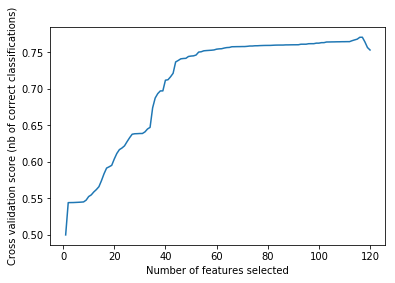

Wall time: 2h 46min 11s


In [30]:
%%time
#train model
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5),
              scoring='roc_auc')

rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
#model = clf.fit(X_train, y_train)
#print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
#print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

In [31]:
print(rfecv.support_)  # The mask of selected features.
print(rfecv.ranking_)

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


In [34]:
print(rfecv.grid_scores_)

[0.50003219 0.54425443 0.54432581 0.54437118 0.54455423 0.54472573
 0.54493834 0.54521894 0.5476509  0.55260556 0.55484111 0.55888082
 0.56212797 0.5660742  0.57439553 0.58378827 0.5915693  0.5933548
 0.59530485 0.60397677 0.61157166 0.61683028 0.61903118 0.62199818
 0.62774957 0.63313737 0.6379375  0.63858554 0.6387168  0.63892576
 0.6389471  0.64113074 0.6451112  0.64734385 0.67409541 0.68752637
 0.69354439 0.69724053 0.69732809 0.7119382  0.71254221 0.71658417
 0.72137121 0.73692639 0.73895192 0.74118453 0.74167117 0.74190386
 0.74441456 0.74499558 0.74529257 0.74645307 0.75045009 0.75090554
 0.75219469 0.75251525 0.75277403 0.75300358 0.75339672 0.75443943
 0.75486577 0.7550571  0.75598818 0.75661823 0.75682488 0.75776582
 0.75780441 0.75790619 0.75793189 0.75802649 0.75803074 0.75834272
 0.75875622 0.75876367 0.75908342 0.75912726 0.75933251 0.75945345
 0.75955243 0.75958487 0.75960618 0.75980018 0.75997948 0.76004645
 0.76007229 0.76008101 0.76030527 0.76031378 0.76039431 0.76044

In [35]:
print(rfecv.estimator_)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [38]:
x_cols = list(X_train.columns.values)
df = pd.DataFrame(x_cols)
df.head()

,0
0,Unnamed: 0
1,gender
2,Anxiety
3,Depression
4,Drowsiness


In [48]:
rfe_support = rfecv.support_
df['rfe_support'] = rfe_support
df.head(120)

,0,rfe_support
0,Unnamed: 0,False
1,gender,True
2,Anxiety,True
3,Depression,True
4,Drowsiness,True
5,Lack_of_Appetite,True
6,Nausea,True
7,Pain,True
8,Shortness_of_Breath,True
9,Tiredness,True


In [54]:
df.loc[df['rfe_support'] == False]

,0,rfe_support
0,Unnamed: 0,False
25,5_visit_max_nausea,False
32,3_visit_mean_drowsiness,False
